In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures

In [5]:
path = "C:/Users/Alex/Coursera/IBM Data Science/Python Data Analysis/Module 5/laptop_pricing.csv"
df = pd.read_csv(path)
df.head()

,Unnamed: 0.1,Unnamed: 0,Manufacturer,Category,GPU,OS,CPU_core,Screen_Size_inch,CPU_frequency,RAM_GB,Storage_GB_SSD,Weight_pounds,Price,Price-binned,Screen-Full_HD,Screen-IPS_panel
0,0,0,Acer,4,2,1,5,14.0,0.551724,8,256,3.52800,978,Low,0,1
1,1,1,Dell,3,1,1,3,15.6,0.689655,4,256,4.85100,634,Low,1,0
2,2,2,Dell,3,1,1,7,15.6,0.931034,8,256,4.85100,946,Low,1,0
3,3,3,Dell,4,2,1,5,13.3,0.551724,8,128,2.69010,1244,Low,0,1
4,4,4,HP,4,2,1,7,15.6,0.620690,8,256,4.21155,837,Low,1,0


In [6]:
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
df.head()

,Manufacturer,Category,GPU,OS,CPU_core,Screen_Size_inch,CPU_frequency,RAM_GB,Storage_GB_SSD,Weight_pounds,Price,Price-binned,Screen-Full_HD,Screen-IPS_panel
0,Acer,4,2,1,5,14.0,0.551724,8,256,3.52800,978,Low,0,1
1,Dell,3,1,1,3,15.6,0.689655,4,256,4.85100,634,Low,1,0
2,Dell,3,1,1,7,15.6,0.931034,8,256,4.85100,946,Low,1,0
3,Dell,4,2,1,5,13.3,0.551724,8,128,2.69010,1244,Low,0,1
4,HP,4,2,1,7,15.6,0.620690,8,256,4.21155,837,Low,1,0


# Using Cross Validation to Improve The Model

In [7]:
# Splitting the dataset

x_data = df.drop('Price', axis = 1)
y_data = df['Price']

In [8]:
# Creating training and testing subsets and setting 10% of the data for testing purposes.

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.10, random_state = 1)

print("Number of test samples :", x_test.shape[0])
print("Number of training samples :", x_train.shape[0])

Number of test samples : 24
Number of training samples : 214


In [9]:
lre = LinearRegression()

lre.fit(x_train[['CPU_frequency']], y_train)
print(lre.score(x_train[['CPU_frequency']], y_train))
print(lre.score(x_test[['CPU_frequency']], y_test))

0.14829792099817973
-0.06599437350393766


In [10]:
# Running a 4-fold cross validation on the model.

Rcross = cross_val_score(lre, x_data[['CPU_frequency']], y_data, cv = 4)
print("The mean of the folds are", Rcross.mean(), "and the standard deviation is", Rcross.std())

The mean of the folds are -0.1610923238859513 and the standard deviation is 0.384957978666471


# Overfitting Analysis

In [11]:
#Creating training and testing subsets and setting 50% of the data for testing purposes.

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.5, random_state = 0)

In [12]:
rsqu_test = []
order = [1, 2, 3, 4, 5]

for n in order:
    pr = PolynomialFeatures(degree = n)
    x_train_pr = pr.fit_transform(x_train[['CPU_frequency']])
    x_test_pr = pr.fit_transform(x_test[['CPU_frequency']])
    lre.fit(x_train_pr, y_train)
    rsqu_test.append(lre.score(x_test_pr, y_test))

Text(0.5, 1.0, 'R^2 Using Test Data')

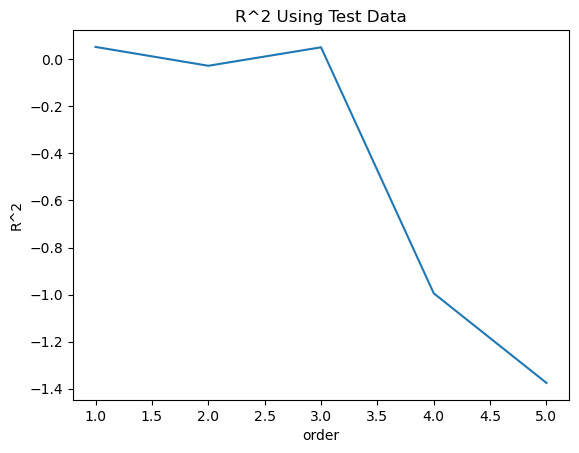

In [13]:
plt.plot(order, rsqu_test)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 Using Test Data')

# Ridge Regression

In [14]:
# Creating polynomial feature model with a degree of 2 that has various parameters.

pr = PolynomialFeatures(degree = 2)
x_train_pr = pr.fit_transform(x_train[['CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core', 'OS', 'GPU', 'Category']])
x_test_pr = pr.fit_transform(x_test[['CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core', 'OS', 'GPU', 'Category']])

In [15]:
rsqu_test = []
rsqu_train = []
dummy1 = []
Alpha = np.arange(0.001, 1, 0.001)
pbar = tqdm(Alpha)

for alpha in pbar:
    RidgeModel = Ridge(alpha = alpha)
    RidgeModel.fit(x_train_pr, y_train)
    test_score, train_score = RidgeModel.score(x_test_pr, y_test), RidgeModel.score(x_train_pr, y_train)
    pbar.set_postfix({"Test Score": test_score, "Train Score": train_score})
    rsqu_test.append(test_score)
    rsqu_train.append(train_score)

100%|██████████| 999/999 [00:02<00:00, 386.52it/s, Test Score=0.423, Train Score=0.669]


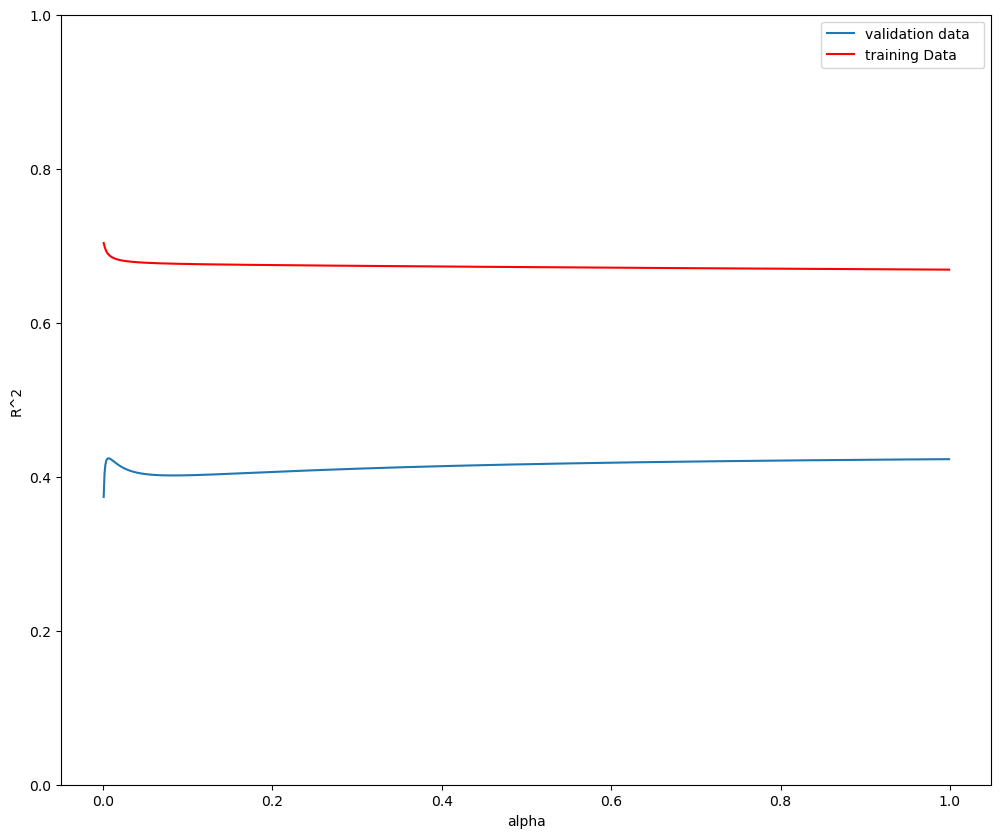

In [16]:
# PLotting R^2 values for training and testing sets with respect to alpha

width = 12
height = 10
plt.figure(figsize=(width, height))

plt.plot(Alpha,rsqu_test, label='validation data  ')
plt.plot(Alpha,rsqu_train, 'r', label='training Data ')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.ylim(0,1)
plt.legend()

# Grid Search

In [17]:
# Assigning a set of alpha values and setting it to a variable.

parameters1= [{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}]
parameters1

[{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}]

In [18]:
# Creating a Ridge instance and running Grid Search using a 4 fold cross validation.

RR = Ridge()
Grid1 = GridSearchCV(RR, parameters1, cv = 4)

In [19]:
# Fitting the data.

Grid1.fit(x_train[['CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core', 'OS', 'GPU', 'Category']], y_train)

GridSearchCV(cv=4, estimator=Ridge(),
             param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}])

In [20]:
# Printing R^2.

BestRR = Grid1.best_estimator_
print(BestRR.score(x_test[['CPU_frequency', 'RAM_GB', 'Storage_GB_SSD', 'CPU_core','OS','GPU','Category']], y_test))

0.3009905048691819
